In [1]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap
import aggmap

warnings.filterwarnings("ignore")

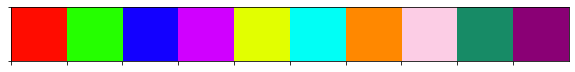

In [2]:
color_list = ['#ff0c00','#25ff00', '#1300ff','#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'] #colors for different channels
sns.palplot(color_list)

In [3]:
data_save_folder = '/raid/shenwanxiang/aggmap/fmnist/correlation/'

metric = 'correlation' # similarity measurement
var_thr = 0 # feature variance should larger than 0

if not os.path.exists(data_save_folder):
    os.makedirs(data_save_folder)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() #(x_train, y_train), (x_test, y_test)
mnist_labels_dict = {0: 'T-shirt/top',1: 'Trouser',2: 'Pullover',
                     3: 'Dress',4: 'Coat', 5: 'Sandal', 
                     6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

## 1) orignal(c=1): OR1

In [5]:
## 1) orignal(c=1): OR1
_, w, h = x_train.shape
trainX_OR1 = x_train.reshape(x_train.shape[0], w, h, 1)
testX_OR1 = x_test.reshape(x_test.shape[0], w, h, 1)

dump((trainX_OR1, testX_OR1),  os.path.join(data_save_folder, '01_X_OR1.data')) 

['/raid/shenwanxiang/aggmap/fmnist/correlation_10/01_X_OR1.data']

# A. shuffle

In [6]:
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)
shuffled_cols = shuffle(orignal_cols, random_state=7)
x_train_df = x_train_df[shuffled_cols]
x_test_df = x_test_df[shuffled_cols]

## 2) ORS1: 

In [7]:
## 2) shuffle(c=1): ORS1
trainX_ORS1 = x_train_df.values.reshape(-1, w, h, 1)
testX_ORS1 = x_test_df.values.reshape(-1, w, h, 1)
dump((trainX_ORS1, testX_ORS1),  os.path.join(data_save_folder, '02_X_ORS1.data')) 

['/raid/shenwanxiang/aggmap/fmnist/correlation_10/02_X_ORS1.data']

In [8]:
mp_train = AggMap(x_train_df, metric = metric)
mp_test = AggMap(x_test_df, metric = metric)

mp_train.save(os.path.join(data_save_folder, 'train.mp'))
mp_test.save(os.path.join(data_save_folder, 'test.mp'))

2020-08-11 12:17:45,898 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-11 12:17:45,934 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:02<00:00, 332.22it/s]

2020-08-11 12:18:42,695 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-11 12:18:42,729 - INFO - [bidd-aggmap] - the number of process is 16



100%|##########| 784/784 [00:01<00:00, 683.07it/s]


['/raid/shenwanxiang/aggmap/fmnist/correlation_10/test.mp']

## 03) orignal_shuffle_agglomerate(c=1): ORSAgg1

In [9]:
## orignal_shuffle_agglomerate(c=1): ORSAgg1
mp_ORSAgg1 = mp_train.copy().fit(verbose = 0, var_thr = var_thr, feature_group_list=['feature_point' for i in range(w*h)], 
                        group_color_dict = {'feature_point':color_list[0]})

trainX_ORSAgg1 = mp_ORSAgg1.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAgg1 = mp_ORSAgg1.batch_transform(x_test_df.values, scale = False, n_jobs = 10)
mp_ORSAgg1.save(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
dump((trainX_ORSAgg1, testX_ORSAgg1),  os.path.join(data_save_folder, '03_X_ORSAgg1.data')) 

2020-08-11 12:18:59,690 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/60000 [00:00<?, ?it/s]

2020-08-11 12:19:00,767 - INFO - [bidd-aggmap] - Finished


100%|##########| 10000/10000 [00:32<00:00, 306.75it/s]


['/raid/shenwanxiang/aggmap/fmnist/correlation_10/03_X_ORSAgg1.data']

# B. cluster channels

## 04) orignal_shuffle_agglomerate_cluster(c=4): ORSAggC4

In [10]:
## 04) orignal_shuffle_agglomerate_cluster(c=4): ORSAggC4
mp_ORSAggC4 = mp_train.copy().fit(verbose = 0, cluster_channels=4, var_thr = var_thr, 
                         group_color_dict = dict(zip(['cluster_01', 'cluster_02', 'cluster_03', 'cluster_04'],color_list[:4])))

trainX_ORSAggC4 = mp_ORSAggC4.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAggC4 = mp_ORSAggC4.batch_transform(x_test_df.values, scale = False, n_jobs = 10)

mp_ORSAggC4.save(os.path.join(data_save_folder, 'mp_ORSAggC4.mp'))
dump((trainX_ORSAggC4, testX_ORSAggC4),  os.path.join(data_save_folder, '04_X_ORSAggC4.data')) 

2020-08-11 12:22:49,083 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-11 12:22:50,437 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/60000 [00:00<?, ?it/s]

2020-08-11 12:22:51,484 - INFO - [bidd-aggmap] - Finished


100%|##########| 10000/10000 [00:40<00:00, 249.50it/s]


['/raid/shenwanxiang/aggmap/fmnist/correlation_10/04_X_ORSAggC4.data']

## 05) orignal_shuffle_agglomerate_cluster(c=10): ORSAggC10

In [ ]:
## 05) orignal_shuffle_agglomerate_cluster(c=4): ORSAggC4
mp_ORSAggC10 = mp_train.copy().fit(verbose = 0, cluster_channels=10, var_thr = var_thr, 
                         group_color_dict = dict(zip(['cluster_%s' % str(i).zfill(2) for i in range(10)],color_list)))
trainX_ORSAggC10 = mp_ORSAggC10.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAggC10 = mp_ORSAggC10.batch_transform(x_test_df.values, scale = False, n_jobs = 10)

mp_ORSAggC10.save(os.path.join(data_save_folder, 'mp_ORSAggC10.mp'))
dump((trainX_ORSAggC10, testX_ORSAggC10),  os.path.join(data_save_folder, '05_X_ORSAggC10.data')) 

2020-08-11 12:27:03,274 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-11 12:27:04,637 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/60000 [00:00<?, ?it/s]

2020-08-11 12:27:05,717 - INFO - [bidd-aggmap] - Finished


 49%|####8     | 29118/60000 [03:16<03:24, 150.81it/s]

# C. self-difined channel

In [ ]:
# self-difined channel
self_color_dict = dict(zip(['area-1', 'area-2', 'area-3', 'area-4'], color_list[:4]))

# split area as channels
area = []
for i, arr in enumerate(np.array_split(range(28*28), 4)):
    area.append(['area-%s' % (i+1) for k in arr])
f = np.array(list(chain(*area))).reshape(28,28, order = 'f')
v_list = f.reshape(28*28).tolist()
v_list = pd.Series(shuffled_cols).map(dict(zip(orignal_cols, v_list))).to_list()


## 6) orignal_shuffle_agglomerate_vertical(c=4): ORSAggV4

In [ ]:
## 6) ORSAggV4
mp_ORSAggV4 = mp_train.copy().fit(verbose = 0, feature_group_list = v_list, var_thr = var_thr, 
                         group_color_dict = self_color_dict)
trainX_ORSAggV4 = mp_ORSAggV4.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAggV4 = mp_ORSAggV4.batch_transform(x_test_df.values, scale = False, n_jobs = 10)

mp_ORSAggV4.save(os.path.join(data_save_folder, 'mp_ORSAggV4.mp'))
dump((trainX_ORSAggV4, testX_ORSAggV4),  os.path.join(data_save_folder, '06_X_ORSAggV4.data')) 